# Коллеги, добрый день!

Предлагаю вам ознакомиться с отчетом по A/B-тестированию новой механики оплаты услуг на сайте.  
Внутри отчета подсветим следующие вопросы:

#### * На какие метрики опиралось исследование и почему?  
#### * Имеются ли различия в показателях и с чем они могут быть связаны?  
#### * Являются ли эти различия статистически значимыми?  
#### * Стоит ли запускать новую механику на всех пользователей?  



### Этап 1 - подготовительный
Датасеты были загружены и переименованы согласно имени из задания предворительно  
Далее загружаем необхдмые нам библиотеки для анализа данных:

In [2]:
import pandas as pd # Анализ и манипуляции с табличными данными (DataFrame)

import numpy as np  # Численные операции, работа с массивами и линейной алгеброй

from tqdm.auto import tqdm # Индикатор прогресса для циклов (визуализация выполнения)

import seaborn as sns   # Визуализация данных (удобные графики поверх matplotlib)

import matplotlib.pyplot as plt  # Построение графиков (низкоуровневая библиотека)

from matplotlib_venn import venn3, venn3_circles #  для диаграммы Венна

from scipy.stats import norm   # Статистические функции (нормальное распределение и тесты)

import re #  Регулярные выражения для работы с текстом

import random # Для генерации таблицы из 3 задания

from scipy.stats import shapiro # для проверки нормальности по итогам первого ревью 

import statistics


Теперь ознакомимся с таблицами: обратим вимание на структуру данных и получим базовую информацию о таблице. 
На что обращаем внимание?  
- Наличие столбцов и их названия  
- Примеры значений  
- Типы данных в каждом столбце
- Пропуски
- Уникальные значения



Таблица groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [3]:
groups = pd.read_csv('groups.csv', sep=';')
print(groups.head(), '\n')
print(groups.info(), '\n')
print('Уникальных ID в датасете:', groups.id.nunique())

     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None 

Уникальных ID в датасете: 74484


Таблица groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [4]:
groups_add = pd.read_csv('groups_add.csv', sep=',')
print(groups_add.head(), '\n')
print(groups_add.info(), '\n')
print('Уникальных ID в датасете:', groups_add.id.nunique())

        id grp
0  5694584   B
1  5694830   B
2  5695057   B
3  5698872   B
4  5699067   B 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
None 

Уникальных ID в датасете: 92


Таблица active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

In [5]:
active_studs = pd.read_csv('active_studs.csv', sep=';')
print(active_studs.head(), '\n')
print(active_studs.info(), '\n')
print('Уникальных student_id в датасете:', active_studs.student_id.nunique())

   student_id
0      581585
1     5723133
2     3276743
3     4238589
4     4475369 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None 

Уникальных student_id в датасете: 8341


Таблица checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента

In [6]:
checks = pd.read_csv('checks.csv', sep=';')
print(checks.head(), '\n')
print(checks.info(), '\n')
print('Уникальных student_id в датасете:', checks.student_id.nunique())

   student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0
3       26280  690.0
4      100300  990.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB
None 

Уникальных student_id в датасете: 541


Теперь соединим groups и groups_add, так как они являются общей базой пользователей для эксперемента  
Назавем новый датафрейм groups_total и посмотрим на него:

In [7]:
groups_total = pd.concat([groups, groups_add])
print(groups_total.head(), '\n')
print(groups_total.info(), '\n')
print('Уникальных ID в датасете:', groups_total.id.nunique())


     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB
None 

Уникальных ID в датасете: 74576


Посомтрим, как пользователи поделены по группам:

In [8]:
print("Распределение пользователей:")
print(groups_total['grp'].value_counts())
counts = groups_total['grp'].value_counts(normalize=True) * 100
print("Процентное соотношение пользователей:")
print(counts.round(2).astype(str) + '%')

Распределение пользователей:
B    59883
A    14693
Name: grp, dtype: int64
Процентное соотношение пользователей:
B    80.3%
A    19.7%
Name: grp, dtype: object


Теперь необходмо проверить, есть ли в датафреймах пользователи, которые попали туда случайно:
- Студенты, которые оплатили обучение, но не попали в список активных во время тестирования - например, если оплата прошла автоматически
- Студенты, которые оплатили обучение, но не попали в общий список groups_total
- Студенты, которые были активны, но не попали в общий список groups_total

In [9]:
paid_not_active = checks[~checks.student_id.isin(active_studs.student_id)]
paid_not_in_total = checks[~checks.student_id.isin(groups_total.id)]
active_not_in_total = active_studs[~active_studs.student_id.isin(groups_total.id)]

print(f'''
Студенты, которые оплатили обучение, но не попали в список активных во время тестирования: {len(paid_not_active)}
Студенты, которые оплатили обучение, но не попали в общий список groups_total: {len(paid_not_in_total)}
Количество пользователей из списка активных, но не вошедших в общий список: {len(active_not_in_total)}
''')


Студенты, которые оплатили обучение, но не попали в список активных во время тестирования: 149
Студенты, которые оплатили обучение, но не попали в общий список groups_total: 0
Количество пользователей из списка активных, но не вошедших в общий список: 0



Теперь проверим оплату по группам:

In [10]:
checks_in_groups = groups_total[groups_total['id'].isin(checks['student_id'])]

group_counts = checks_in_groups['grp'].value_counts()

print('Распределение оплат по группам:',
      f'\nГруппа A: {group_counts.get("A", 0)}',
      f'\nГруппа B: {group_counts.get("B", 0)}',
      f'\nВсего:   {group_counts.sum()}')

Распределение оплат по группам: 
Группа A: 107 
Группа B: 434 
Всего:   541


Теперь проверим группу оплативших, но не попавших в тестирование(!= активные):

In [11]:
paid_not_active_in_groups = groups_total[groups_total['id'].isin(paid_not_active['student_id'])]

group_counts = paid_not_active_in_groups['grp'].value_counts()

print('Оплатили, но не попали в тестрование:',
      f'\nГруппа A: {group_counts.get("A", 0)}',
      f'\nГруппа B: {group_counts.get("B", 0)}',
      f'\nВсего:   {group_counts.sum()}')

Оплатили, но не попали в тестрование: 
Группа A: 29 
Группа B: 120 
Всего:   149


Как по гуппам распредлены студенты, участвовавшие в тестировании (= активные)?

In [12]:
active_in_groups = groups_total[groups_total['id'].isin(active_studs['student_id'])]

group_counts = active_in_groups['grp'].value_counts()

print('Распределение участвовавших в тестировании по группам:',
      f'\nГруппа A: {group_counts.get("A", 0)}',
      f'\nГруппа B: {group_counts.get("B", 0)}',
      f'\nВсего:   {group_counts.sum()}')


Распределение участвовавших в тестировании по группам: 
Группа A: 1538 
Группа B: 6803 
Всего:   8341


Как по гуппам распредлены студенты, участвовавшие в тестировании (= активные), которые совершили оплату?

In [13]:
active_paid_users = groups_total[
    groups_total['id'].isin(active_studs['student_id']) & 
    groups_total['id'].isin(checks['student_id'])
]

group_counts = active_paid_users['grp'].value_counts()

print('Участвовавшие в тестировании оплатившие пользователи по группам:',
      f'\nГруппа A: {group_counts.get("A", 0)}',
      f'\nГруппа B: {group_counts.get("B", 0)}',
      f'\nВсего:   {group_counts.sum()}')

Участвовавшие в тестировании оплатившие пользователи по группам: 
Группа A: 78 
Группа B: 314 
Всего:   392


Сколько студентов участвовало в тестировании но не оплатило?

In [14]:
active_not_paid = groups_total[
    groups_total['id'].isin(active_studs['student_id']) & 
    ~groups_total['id'].isin(checks['student_id'])
]

group_counts = active_not_paid['grp'].value_counts()

print('Участвовавшие в тестировании, но не оплатившие пользователи, количество по группам:',
      f'\nГруппа A: {group_counts.get("A", 0)}',
      f'\nГруппа B: {group_counts.get("B", 0)}',
      f'\nВсего:   {group_counts.sum()}')

Участвовавшие в тестировании, но не оплатившие пользователи, количество по группам: 
Группа A: 1460 
Группа B: 6489 
Всего:   7949


Из полученных данных можно составить диаграмму Венна - это наглядно покажет, каие группы пользователей есть и как они разбиты по группам 

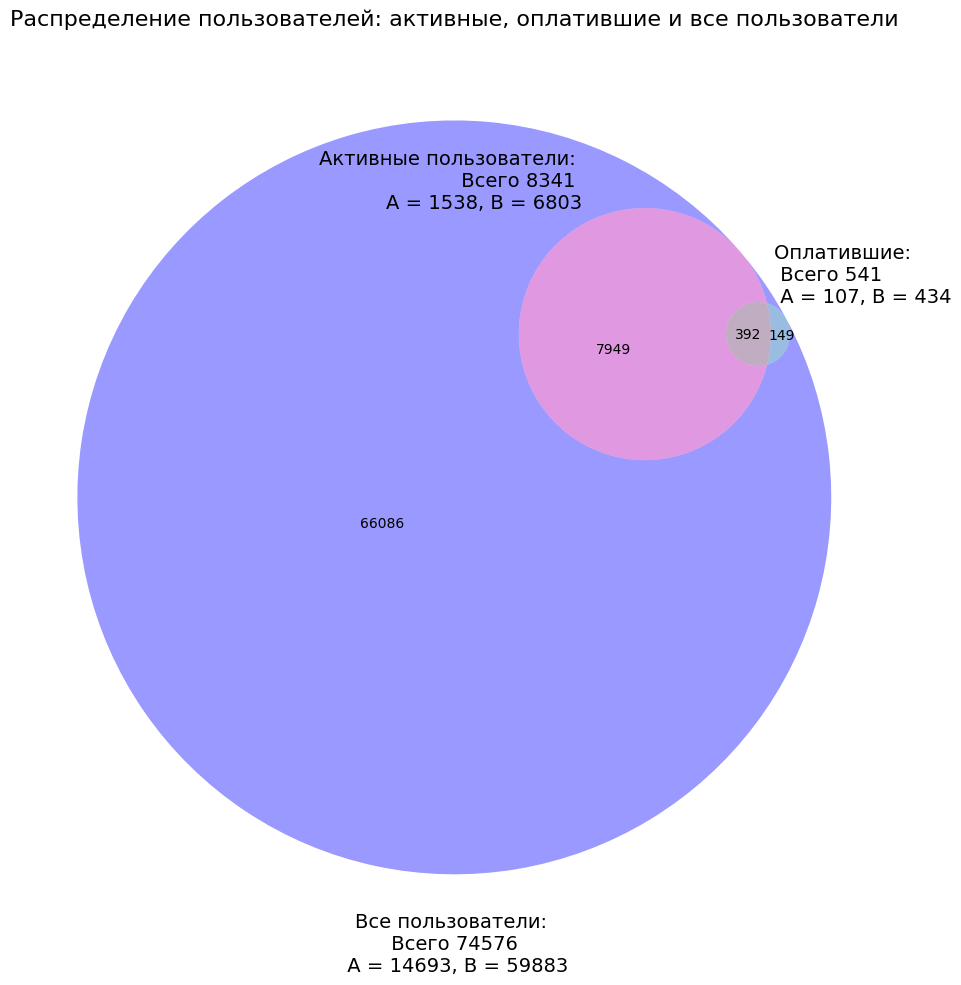

In [15]:
all_users = set(groups_total['id'])

active_users = set(active_studs['student_id'])

paid_users = set(checks['student_id'])

plt.figure(figsize=(12, 10), dpi=100)


v = venn3([active_users, paid_users, all_users], ('Активные пользователи: \n Всего 8341 \nA = 1538, B = 6803', 'Оплатившие: \n Всего 541 \n A = 107, B = 434', 'Все пользователи: \n Всего 74576 \n A = 14693, B = 59883'))

for text in v.set_labels:
    text.set_fontsize(14)

plt.title("Распределение пользователей: активные, оплатившие и все пользователи", 
          fontsize=16, pad=20)
plt.tight_layout()
plt.show()

Из диаграммы наглядно видно, что:
- поьзователей, который поучаствовали в тестировании (активных) немного относительно всех пользователей
- участников тестирования значительно больше в группе В
- оплативших пользователей, которые не участвовали в тестировании достаточно много. У нас нет данных о технических процессах в компании, так что мы не можем однозначно сказать, кто эти люди (как было написано выше, это может быть автоматическая оплата). Поскольку они не попали в категорию активных пользователей, мы будем считать, что они не участвовали в эксерименте

### Вывод первого этапа:

В дальнейшем анализе результатов тестирования будем смотреть 392 человека - студентов, одновременно оплативших и активных (серая часть окружности на диаграмме)



### Этап 2 - Анализ выборки

Для начала объеденим таблицу со всеми активными и оплатившими пользователями (розовая и серая области)
Дополнительно на будущее переименуем колонку айди для краткости и удобства

In [16]:
active_checks = (active_studs.merge(checks, how='left', on='student_id').rename(columns={'student_id': 'id'})
                )
active_checks.query('rev.notna()').info()
active_checks.query('rev.notna()').head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 62 to 8339
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      392 non-null    int64  
 1   rev     392 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 9.2 KB


,id,rev
62,1184303,1530.0000
67,3354191,1900.0001
77,3278734,1900.0000
99,720651,1980.0000
193,1232221,1900.0000


Объединим активных оплативших из предыдущего шага с groups_total, оставив только активных (нам нужны розовая и серая области c данными о группах):

In [17]:
active_total = groups_total.merge(active_checks, how='right', on='id')
active_total.info()
active_total.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8341 non-null   int64  
 1   grp     8341 non-null   object 
 2   rev     392 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 260.7+ KB


,id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


Добавим колонку со статусом оплаты (0 - не оплачен, 1 - оплачен):


In [18]:

active_total['payment'] = active_total.rev.apply(lambda x: 0 if np.isnan(x) else 1)
active_total.query('rev.isna()').info()
active_total.query('rev.isna()').head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7949 entries, 0 to 8340
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       7949 non-null   int64  
 1   grp      7949 non-null   object 
 2   rev      0 non-null      float64
 3   payment  7949 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 310.5+ KB


,id,grp,rev,payment
0,581585,A,NaN,0
1,5723133,A,NaN,0
2,3276743,B,NaN,0
3,4238589,A,NaN,0
4,4475369,B,NaN,0


Работать с NaN не удобно, поменяем NaN на 0:

In [19]:
active_total['rev'] = active_total.rev.fillna(0)


Сформируем датафрейм со всей собранной информацией. Активные + оплатившие (серая зона):





In [20]:
active_total_paid = active_total.query('rev != 0')
active_total_paid.info()
active_total_paid.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 62 to 8339
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       392 non-null    int64  
 1   grp      392 non-null    object 
 2   rev      392 non-null    float64
 3   payment  392 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 15.3+ KB


,id,grp,rev,payment
62,1184303,A,1530.0000,1
67,3354191,B,1900.0001,1
77,3278734,B,1900.0000,1
99,720651,A,1980.0000,1
193,1232221,B,1900.0000,1


Создадим группу А:

In [21]:
a_group = active_total.query('grp == "A"')
a_group.info()
a_group.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1538 entries, 0 to 8334
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1538 non-null   int64  
 1   grp      1538 non-null   object 
 2   rev      1538 non-null   float64
 3   payment  1538 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 60.1+ KB


,id,grp,rev,payment
0,581585,A,0.0,0
1,5723133,A,0.0,0
3,4238589,A,0.0,0
7,1394612,A,0.0,0
21,5194768,A,0.0,0


Создадим подгруппу оплативших в группе А:


In [22]:
a_group_paid = a_group.query('rev > 0')
a_group_paid.info()
a_group_paid.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 62 to 8263
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       78 non-null     int64  
 1   grp      78 non-null     object 
 2   rev      78 non-null     float64
 3   payment  78 non-null     int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 3.0+ KB


,id,grp,rev,payment
62,1184303,A,1530.0,1
99,720651,A,1980.0,1
306,4337103,A,580.0,1
392,332387,A,2910.0,1
439,1659434,A,690.0,1


Проделываем аналогичное для группы В
Активные пользователи, группа B:

In [23]:
b_group = active_total.query('grp == "B"')
b_group.info()
b_group.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6803 entries, 2 to 8340
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       6803 non-null   int64  
 1   grp      6803 non-null   object 
 2   rev      6803 non-null   float64
 3   payment  6803 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 265.7+ KB


,id,grp,rev,payment
2,3276743,B,0.0,0
4,4475369,B,0.0,0
5,5481015,B,0.0,0
6,1353433,B,0.0,0
8,1170611,B,0.0,0


Активные оплатившие пользователи, группа B:

In [24]:
b_group_paid = b_group.query('rev > 0')
b_group_paid.info()
b_group_paid.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 314 entries, 67 to 8339
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       314 non-null    int64  
 1   grp      314 non-null    object 
 2   rev      314 non-null    float64
 3   payment  314 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 12.3+ KB


,id,grp,rev,payment
67,3354191,B,1900.0001,1
77,3278734,B,1900.0000,1
193,1232221,B,1900.0000,1
195,3821501,B,1900.0000,1
211,1036096,B,1900.0000,1


##### Теперь проверим распределение пользователей в группах по сумме оплаты:
На этом этапе можно решить, есть ли в группах каие-то особенности

Text(0, 0.5, 'Количество наблюдений')

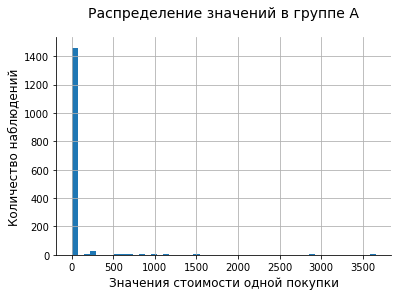

In [25]:
a_group.rev.hist(bins=50)
sns.despine()
plt.title('Распределение значений в группе A', pad=20, fontsize=14)
plt.xlabel('Значения стоимости одной покупки', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)


Text(0, 0.5, 'Количество наблюдений')

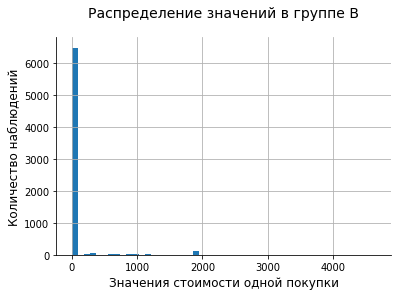

In [26]:
b_group.rev.hist(bins=50)
sns.despine()
plt.title('Распределение значений в группе В', pad=20, fontsize=14)
plt.xlabel('Значения стоимости одной покупки', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)

Text(0, 0.5, 'Количество наблюдений')

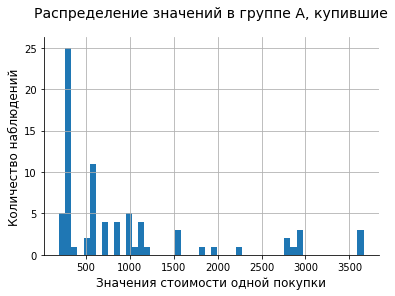

In [27]:
a_group_paid.rev.hist(bins=50)
sns.despine()
plt.title('Распределение значений в группе A, купившие', pad=20, fontsize=14)
plt.xlabel('Значения стоимости одной покупки', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)

Text(0, 0.5, 'Количество наблюдений')

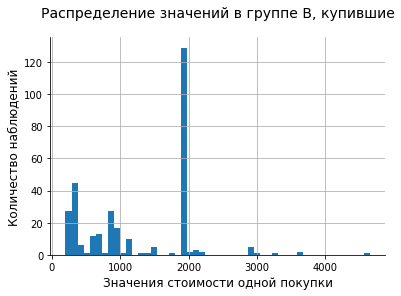

In [28]:
b_group_paid.rev.hist(bins=50)
sns.despine()
plt.title('Распределение значений в группе В, купившие', pad=20, fontsize=14)
plt.xlabel('Значения стоимости одной покупки', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)

Если смотреть на группы целиком, то большинство активных студентов ничего не купило
В группах купивших есть пики: А = 250, В = 2000

Посмотрим описательную статистику по стоимости покупки в группах:

In [29]:
a_stats = a_group.rev.describe().to_frame().rename(columns={'rev': 'Группа A (все)'})
b_stats = b_group.rev.describe().to_frame().rename(columns={'rev': 'Группа B (все)'})

a_paid_stats = a_group_paid.rev.describe().to_frame().rename(columns={'rev': 'Группа A (оплатившие)'})
b_paid_stats = b_group_paid.rev.describe().to_frame().rename(columns={'rev': 'Группа B (оплатившие)'})

result_table = pd.concat([a_stats, b_stats, a_paid_stats, b_paid_stats], axis=1)

result_table

,Группа A (все),Группа B (все),Группа A (оплатившие),Группа B (оплатившие)
count,1538.000000,6803.000000,78.000000,314.000000
mean,47.347204,58.058798,933.589744,1257.878992
std,290.490632,313.770201,919.932711,790.864254
min,0.000000,0.000000,199.000000,199.000000
25%,0.000000,0.000000,290.000000,511.750000
50%,0.000000,0.000000,585.000000,1140.000000
75%,0.000000,0.000000,1114.750000,1900.000000
max,3660.000000,4650.000000,3660.000000,4650.000000


Есть ли в данных выбросы? 
Для начала оценим всех пользователей

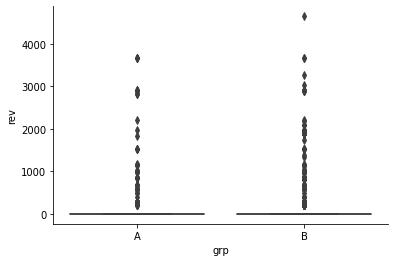

In [31]:
sns.boxplot(data=active_total, y='rev', x='grp')
sns.despine()


Тепрь купиших:

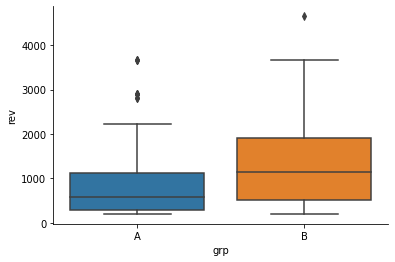

In [32]:
sns.boxplot(data=active_total_paid, y='rev', x='grp')
sns.despine()

Визуально кажется, что выбросы есть. Можно предположить, что выбросы по цене - редкие большие покупки подписок.
Например - максимальные значения в описательно статистике

#### На основе полученных данных, какие метрики лучше использовать?

- CR (Conversion Rate) — это коэффициент конверсии, то есть отношение числа пользователей, совершивших целевое действие на сайте, к общему количеству посетителей. Для нас это будет отношением количество пользователей, совершивших покупку. Важный показатель, так как в теории чем он выше, тем проще пользователю совершить полезное действие
- ARPU (Average Revenue Per User) — это показатель среднего дохода, который компания получает от одного пользователя за определённый период. Проще говоря, сколько в среднем приносит бизнесу каждый клиент. Для нас это будет сумма rev отношению ко всем активным пользователям
- ARPPU (Average Revenue Per Paying User) — средний доход с платящего пользователя. Метрика фокусируется исключительно на клиентах, совершивших покупку. Для нас - тншение суммы rev к числу заплативших активных клиентов

Считать показатели будем отдельно для групп А и В. Устойчивая разница для одной из групп будет результатом проведенного А/В тестирования

Найдем CR:

In [33]:
cr_a = round(a_group_paid.id.count() / a_group.id.count(), 4)
cr_b = round(b_group_paid.id.count() / b_group.id.count(), 4)
diff = round((cr_b - cr_a) / cr_a * 100, 1)

print('\033[1mCR (Conversion Rate)\033[0m')
print('Конверсия оплативших пользователей:')
print(f'Группа A: {cr_a}') 
print(f'Группа B: {cr_b}')

if diff > 0:
    print(f'Конверсия у группы B на {diff}% больше, чем у группы A')
elif diff < 0:
    print(f'Конверсия у группы B на {abs(diff)}% меньше, чем у группы A')
else:
    print('Конверсии в группах A и B равны')

CR (Conversion Rate)
Конверсия оплативших пользователей:
Группа A: 0.0507
Группа B: 0.0462
Конверсия у группы B на 8.9% меньше, чем у группы A


Найдем ARPU:

In [34]:
# Рассчитываем средние значения
arppu_a = round(a_group_paid.rev.mean(), 2)
arppu_b = round(b_group_paid.rev.mean(), 2)
diff_percent = round((arppu_b - arppu_a) / arppu_a * 100, 2)

# Формируем вывод
print('\n\033[1mARPPU\033[0m')
print('Отношение общей суммы на количество активных оплативших пользователей:')
print(f'Группа A: {arppu_a}')
print(f'Группа B: {arppu_b}')

# Сравнение групп
if diff_percent > 0:
    print(f'ARPPU группы B на {diff_percent}% больше, чем у группы A')
elif diff_percent < 0:
    print(f'ARPPU группы B на {abs(diff_percent)}% меньше, чем у группы A')
else:
    print('ARPPU в группах A и B равны')


ARPPU
Отношение общей суммы на количество активных оплативших пользователей:
Группа A: 933.59
Группа B: 1257.88
ARPPU группы B на 34.74% больше, чем у группы A


Найдем ARPPU:

In [35]:
# Рассчитываем ARPU для каждой группы
arpu_a = round(a_group_paid.rev.sum() / a_group.id.count(), 2)
arpu_b = round(b_group_paid.rev.sum() / b_group.id.count(), 2)
difference = round((arpu_b - arpu_a) / arpu_a * 100, 2)

# Формируем вывод
print('\n\033[1mARPU\033[0m')
print('Отношение общей суммы на количество активных пользователей:')
print(f'Группа A: {arpu_a}')
print(f'Группа B: {arpu_b}')

# Сравниваем показатели
if difference > 0:
    print(f'ARPU группы B на {difference}% больше, чем у группы A')
elif difference < 0:
    print(f'ARPU группы B на {abs(difference)}% меньше, чем у группы A')
else:
    print('ARPU в группах A и B равны')


ARPU
Отношение общей суммы на количество активных пользователей:
Группа A: 47.35
Группа B: 58.06
ARPU группы B на 22.62% больше, чем у группы A


Ситуация с выбранными метриками не дает однозначного ответа:
CR дал отрицательный результат, однако ARPU и ARPPU - положительный. 

###### Из-за чего это могло бы произойти?

По итогам первого этапа мы помним, что пользователи распределены по группам неравномерно, в соотношении примерно 1:4. Может ли быть дело в этом?

Чтобы проверить это предположение, нужно дополнительное исследование - bootstrap

Для начала создадим функцию, которая позволит произвести bootstrap-исследование:


In [36]:

def bootstrap_test(
    control,          # Контрольная группа
    test,            # Тестовая группа
    n_iter=1000,     # Количество итераций
    stat=np.mean,    # Статистика для сравнения (по умолчанию среднее)
    conf_level=0.95, # Уровень доверия
    plot=True        # Отрисовывать график
):
    """Упрощенная функция для проверки гипотез методом бутстрапа"""
    
    # 1. Генерируем бутстрап-выборки
    size = max(len(control), len(test))
    diffs = []
    
    for _ in tqdm(range(n_iter)):
        # Бутстрап-выборки с возвращением
        c_sample = control.sample(size, replace=True).values
        t_sample = test.sample(size, replace=True).values
        diffs.append(stat(t_sample - c_sample))
    
    # 2. Рассчитываем доверительный интервал
    ci = np.percentile(diffs, [(1-conf_level)/2*100, (1-(1-conf_level)/2)*100])
    
    # 3. Вычисляем p-value
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs)
    p_val = 2 * min(norm.cdf(0, mean_diff, std_diff), norm.cdf(0, -mean_diff, std_diff))
    
    # 4. Визуализация
    if plot:
        plt.hist(diffs, bins=50, alpha=0.7)
        plt.axvline(ci[0], color='red', linestyle='--')
        plt.axvline(ci[1], color='red', linestyle='--')
        plt.title('Bootstrap Distribution of Differences')
        plt.show()
    
    return {'confidence_interval': ci, 'p_value': p_val}



##### CR

Сформулируем нулевую и альтернативную гипотезы:

H0: CR в двух группах одинаковые.  
H1: CR в двух группах различаются.

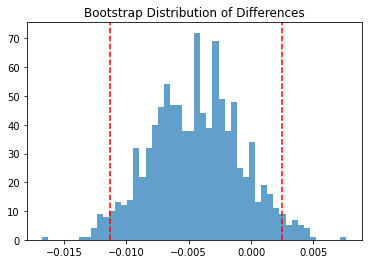

{'confidence_interval': array([-0.01131854,  0.00250257]),
 'p_value': 0.21410858575175873}

In [37]:
bootstrap_test(a_group.payment, b_group.payment)

Доверительный интервал попадает в 0, недостаточно оснований отвергнуть нулевую гипотезу. Нельзя утверждать, что различия CR в двух группах есть.

##### ARPU
Сформулируем нулевую и альтернативную гипотезы:

H0: ARPU в двух группах одинаковые.  
H1: ARPU в двух группах различаются.

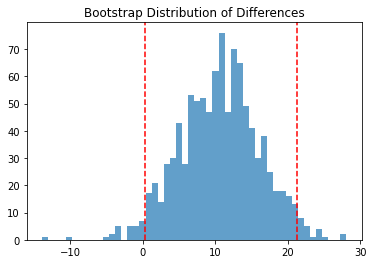

{'confidence_interval': array([ 0.33537444, 21.22805442]),
 'p_value': 0.052675423383389694}

In [38]:
bootstrap_test(a_group.rev, b_group.rev)


Доверительный интервал не попадает в 0, отвергаем нулевую гипотезу. ARPU в двух группах различаются.



##### ARPPU
Сформулируем нулевую и альтернативную гипотезы:

H0: ARPPU в двух группах одинаковые.  
H1: ARPPU в двух группах различаются.

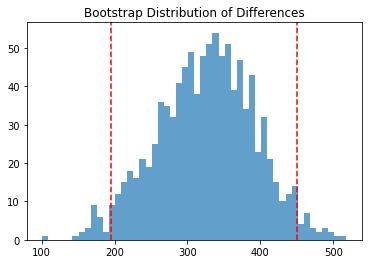

{'confidence_interval': array([195.55773214, 450.10677682]),
 'p_value': 8.972057104206661e-07}

In [39]:
bootstrap_test(a_group.rev[a_group.rev > 0], b_group.rev[b_group.rev > 0])


     

Доверительный интервал не попадает в 0, отвергаем нулевую гипотезу. ARPPU в двух группах различаются.

### Этап 3: Вывод

Стоит ли запускать новую механику на всех пользователей?  
Да, новая механика оплаты даёт статистически значимый прирост в метриках ARPU и ARPPU, отрицательное изменение метрики CR не подтвердилось.

### Этап 4: Update по итогам обратной связи

В результате проверки проекта была получена обратная связь - внутри проекта не были исследованы дисперсии выброк. Исправим данный недочет

#### Оценим дисперсию в 2-х группах:  группе оплативших А, группе оплаивших В. Дополнительно посмотрим стандартное отклонение

Нулевая гипотеза - дисперсии равны. Это будет означать, что доработка, которую смотрели в А/В тесте, не повлияла на разброс показателей суммы покупки  
Альтернативная гипотеза - дисперсии не равны. Это будет означать, что доработка, которую смотрели в А/В тесте, повлияла на разброс показателей суммы покупки  


Для начала извлечем из подборок выше данные, с которыми будем работать - колонки оплаты из двух групп  

In [50]:
a_rev = a_group_paid['rev']
b_rev = b_group_paid['rev']


Посчитаем дисперсию:

In [51]:
var_a = a_rev.var(ddof=1)  # ddof=1 для несмещённой оценки
var_b = b_rev.var(ddof=1)

difference = round((var_b - var_a) / var_a * 100, 2)

print('\n\033[1mДисперсия\033[0m')
print('Дисперсия в группах активных оплативших пользователей:')
print(f"Дисперсия группы A: {var_a}")
print(f"Дисперсия группы В: {var_b}")

# Сравниваем показатели
if difference > 0:
    print(f'Дисперсия группы B на {difference}% больше, чем у группы A')
elif difference < 0:
    print(f'Дисперсия группы B на {abs(difference)}% меньше, чем у группы A')
else:
    print('Дисперсия в группах A и B равны')


Дисперсия
Дисперсия в группах активных оплативших пользователей:
Дисперсия группы A: 846276.1931401932
Дисперсия группы В: 625466.2680387263
Дисперсия группы B на 26.09% меньше, чем у группы A


Дисперсия в группе А больше, чем дисперсия в группе В. Это означает,что подтвердилась альтернативная гипотеза - дисперсии не равны.   
Для нашего исследования более высокий показатель дисперсии говорит о большей непредсказуемости бизнес-результата, что может означать более высокий риск при прогнозировании. Данный показатель косвенно подтверждает выводы этапа 3 - доработка, которую исследовали в А/В тесте,должна быть рекомендована к промышленной эксплуатации, так как она уменьшила разброс показателей суммы покупки 

Сама по себе дисперсия является математическим показателем - так как при её вычисления мы возводили различия в квадрат, то и дисперсия выражена в квадратных единицах. Чтобы сделать результат более понятным, дополнительно посчитаем стандартное отклонение:

In [52]:
a_std_deviation = a_rev.std()
b_std_deviation = b_rev.std()
difference = round((b_std_deviation - a_std_deviation) / a_std_deviation * 100, 2)

print('\n\033[1mСтандартное отклонение\033[0m')
print('Стандартное отклонение в группах активных оплативших пользователей:')
print(f"Стандартное отклонение группы A: {a_std_deviation:.2f}")
print(f"Стандартное отклонение группы В: {b_std_deviation:.2f}")

# Сравниваем показатели
if difference > 0:
    print(f'Стандартное отклонение группы B на {difference}% больше, чем у группы A')
elif difference < 0:
    print(f'Стандартное отклонение группы B на {abs(difference)}% меньше, чем у группы A')
else:
    print('Стандартное отклонение в группах A и B равны')


Стандартное отклонение
Стандартное отклонение в группах активных оплативших пользователей:
Стандартное отклонение группы A: 919.93
Стандартное отклонение группы В: 790.86
Стандартное отклонение группы B на 14.03% меньше, чем у группы A


Можно сказать, что разброс стоимостей счёта:  
± 919.93 ₽ для группы А  
± 790.86 ₽ для группы В


### Вывод:
Дисперсия и стандартное отклоненеие в группе А выше, чем дисперсия и стандартное отклонение в группе В. Это означает более низкий разброс показателей для группы В и дополнительно подтверждает пользу от внедрения изменения

Так же дополнительно подтвердилась необходимость использовать бутстреп-тест:  
Высокие значения дисперсии указывают на сильный разброс данных, на наличие выбросов, которые искажают параметрические оценки  

Бутстреп не требует предположений о нормальности и устойчив к отклонениям от неё


## Задание 3

###### Так как в задании 3 используется те же данные что и в 1, задания объеденены в общий файл 


##### Условие:
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

##### Для начала нужно подумать, что будет представлять из себя файл groups_add.csv?
Если он будет полностью повторять файл group_add.csv, то есть состоять из 2х колонок id и grp, то для исследования он будет бесполезным - у нас не будет данных о том, была ли произведена оплата и сколько человек заплатил, ведь во вспомогательных уже существующих таблицах active_studs.csv и checks.csv может не быть данных о новых пользователях 

##### Какой ожидаемый результат от данной функции?
По заданию нам необходимо пересчитать метрики с учетом новых данных  

Метрики, которые мы использовали: 

CR (Conversion Rate) — это коэффициент конверсии, то есть отношение числа пользователей, совершивших целевое действие на сайте, к общему количеству посетителей. Для нас это будет отношением количество пользователей, совершивших покупку. Важный показатель, так как в теории чем он выше, тем проще пользователю совершить полезное действие  

ARPU (Average Revenue Per User) — это показатель среднего дохода, который компания получает от одного пользователя за определённый период. Проще говоря, сколько в среднем приносит бизнесу каждый клиент. Для нас это будет сумма rev отношению ко всем активным пользователям  

ARPPU (Average Revenue Per Paying User) — средний доход с платящего пользователя. Метрика фокусируется исключительно на клиентах, совершивших покупку. Для нас - тншение суммы rev к числу заплативших активных клиентов

Считаю, что для большей наглядности функция должна выводить еще и изначальные данные, так будет проще увидеть разницу

Ожидаемый результ: 
Выведенная таблица с двумя строчками: подсчет метрик для старого датафрейма, подсчет метрик с учетом нового датафрейма. Строчки подписаны, метрики обозначены

##### Теперь нужно верхнеуровнево описать будущий алгоритм

1. Нам нужно получить на вход 2 сущности: существующий датафрейм и новую таблицу, которую нам отдадут коллеги
2. Далее нам нужно сохранить новую таблицу ввиде датафрейма
3. Из нового датафрейма берем только активных оплативших пользователей  
4. Необходимо создать таблицу, в которую будут передаваться метрики - она будет нашим ожидаемым результатом
5. Далее подсчитываем метрики для старого датафрейма. Так как одинаковые метрики нужно посчитаьт дважды, этот шаг логично выделить отлелльной функцией
6. Сохраняем получивышиеся метрики в первую строчку датафрема с ожидаемым результатом
7. Объеденяем исходный датафрейм и новый
8. Счиатем метрики для объеденного датафрейма и сохраняем их в датафрейм ожиджаемого результата

##### Как будем тестировать получившуюся функцию?

У нас есть рабочий датафрем, из которого мы подсчитывали метрики в задании 1 - active_total  

Дополнительно нам нужно сгененрировать таблицу, которая будет имитировтаь присланную. Нам уже дали название group_add.csv используем его

Гененрируем таблицу и заполняем ее рандомными данными:  


In [43]:
data = {
    'id': [10000 + i for i in range(5)],
    'grp': random.choices(['A', 'B'], k=5),
    'activity': random.choices([0, 1], k=5),
    'payment': random.choices([0, 1], k=5)
}

# Сначала генерируем все доходы, затем обнуляем где payment=0
data['rev'] = np.round(np.random.uniform(1000, 10000, 5), 2)
data['rev'] = np.where(np.array(data['payment']) == 0, 0, data['rev'])

df = pd.DataFrame(data)

df.to_csv('group_add.csv', index=False)

В сгенерированных рандомных данных нам нужно исключить случаи, когда payment=0, а rev!=0 - данных о сумме оплты не должно быть при отсутсвии признака оплаты payment  
Дополнительно отредактируем получившуюся таблицу

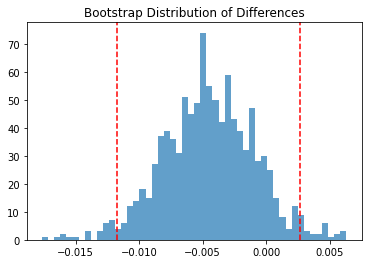

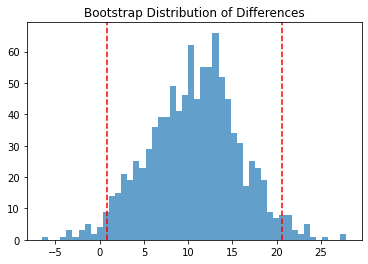

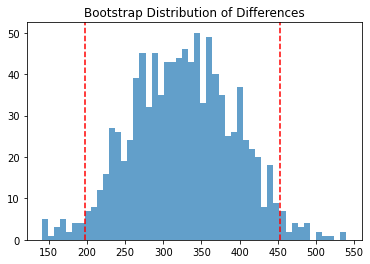

        0  grp         id  payment  rev
0     NaN    A   581585.0      0.0  0.0
1     NaN    A  5723133.0      0.0  0.0
2     NaN    B  3276743.0      0.0  0.0
3     NaN    A  4238589.0      0.0  0.0
4     NaN    B  4475369.0      0.0  0.0
..    ...  ...        ...      ...  ...
0    True  NaN        NaN      NaN  NaN
1    True  NaN        NaN      NaN  NaN
2    True  NaN        NaN      NaN  NaN
3    True  NaN        NaN      NaN  NaN
4   False  NaN        NaN      NaN  NaN

[8346 rows x 5 columns]


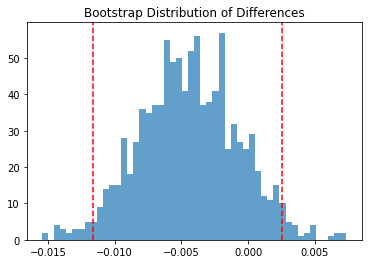

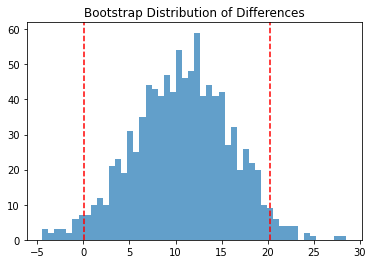

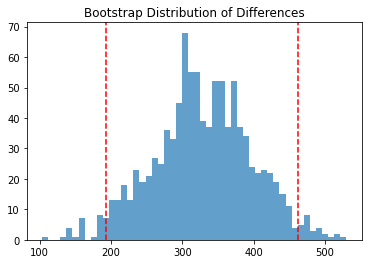

,CR_A,CR_B,CR_p-value,ARPU_A,ARPU_B,ARPU_p-value,ARPPU_A,ARPPU_B,ARPPU_p-value
До объединения,0.050715,0.046156,0.211924,47.347204,58.058798,0.036379,933.589744,1257.878992,0.000001
После объединения,0.050715,0.046156,0.229511,47.347204,58.058798,0.040282,933.589744,1257.878992,0.000002


In [52]:
import pandas as pd
import numpy as np

def get_update(work_df, new_df="group_add.csv"):
    # Загружаем дополнительные данные
    group_add_df = pd.read_csv(new_df)
    group_add_df = (group_add_df['activity'] == 1) 
    
    # Создаем DataFrame для результатов
    columns = ['CR_A', 'CR_B', 'CR_p-value',
               'ARPU_A', 'ARPU_B', 'ARPU_p-value',
               'ARPPU_A', 'ARPPU_B', 'ARPPU_p-value']
    df_ab = pd.DataFrame(columns=columns)
    
    # Функция расчета метрик
    def calc_metrics(df):
        # Фильтрация данных
        a_mask = df['grp'] == 'A'
        b_mask = df['grp'] == 'B'
        a_paid_mask = a_mask & (df['rev'] > 0)
        b_paid_mask = b_mask & (df['rev'] > 0)
        
        # Расчет метрик
        return [
            df.loc[a_mask, 'payment'].mean(),  # CR_A
            df.loc[b_mask, 'payment'].mean(),  # CR_B
            bootstrap_test(df.loc[a_mask, 'payment'], 
                         df.loc[b_mask, 'payment'])["p_value"],  # CR_p-value
            np.mean(df.loc[a_mask, 'rev']),  # ARPU_A
            np.mean(df.loc[b_mask, 'rev']),  # ARPU_B
            bootstrap_test(df.loc[a_mask, 'rev'],
                         df.loc[b_mask, 'rev'])["p_value"],  # ARPU_p-value
            np.mean(df.loc[a_paid_mask, 'rev']),  # ARPPU_A
            np.mean(df.loc[b_paid_mask, 'rev']),  # ARPPU_B
            bootstrap_test(df.loc[a_paid_mask, 'rev'],
                         df.loc[b_paid_mask, 'rev'])["p_value"]  # ARPPU_p-value
        ]
    
    # 1. Расчет для исходных данных
    df_ab.loc['До объединения'] = calc_metrics(work_df)
    
    # 2. Объединение с новыми данными
    work_df =  pd.concat([work_df, group_add_df]) 
    print(work_df)
    
    # 3. Расчет для объединенных данных
    df_ab.loc['После объединения'] = calc_metrics(work_df)
    
    return df_ab
metrix = get_update(active_total, 'group_add.csv')
metrix

#### Задание 2 - отрисовка графика 



In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_metrics(metrics_df):
    """
    Визуализирует результаты A/B теста из DataFrame, возвращенного функцией get_update()
    
    Параметры:
        metrics_df (pd.DataFrame): DataFrame с метриками, содержащий строки 
                                 'До объединения' и 'После объединения'
    """
    # Проверка данных
    if not all(x in metrics_df.index for x in ['До объединения', 'После объединения']):
        raise ValueError("DataFrame должен содержать строки 'До объединения' и 'После объединения'")
    
    # Настройка стиля
    plt.style.use('seaborn')
    sns.set_palette("husl")
    
    # Создаем фигуру с 3 подграфиками
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    fig.suptitle('Сравнение метрик A/B теста до и после объединения данных', fontsize=14)
    
    # 1. График конверсии (CR)
    cr_data = metrics_df[['CR_A', 'CR_B']].stack().reset_index()
    cr_data.columns = ['Этап', 'Группа', 'Значение']
    sns.barplot(x='Этап', y='Значение', hue='Группа', data=cr_data, ax=axes[0])
    axes[0].set_title('Конверсия (CR)')
    axes[0].set_ylabel('Доля конверсии')
    axes[0].set_ylim(0, 1)
    
    # Добавляем p-value
    for i, stage in enumerate(['До объединения', 'После объединения']):
        p_val = metrics_df.loc[stage, 'CR_p-value']
        axes[0].text(i, 0.9, f'p={p_val:.3f}', ha='center', color='red')
    
    # 2. График ARPU
    arpu_data = metrics_df[['ARPU_A', 'ARPU_B']].stack().reset_index()
    arpu_data.columns = ['Этап', 'Группа', 'Значение']
    sns.barplot(x='Этап', y='Значение', hue='Группа', data=arpu_data, ax=axes[1])
    axes[1].set_title('Средний доход на пользователя (ARPU)')
    axes[1].set_ylabel('Доход')
    
    # Добавляем p-value
    for i, stage in enumerate(['До объединения', 'После объединения']):
        p_val = metrics_df.loc[stage, 'ARPU_p-value']
        axes[1].text(i, arpu_data['Значение'].max()*0.9, 
                    f'p={p_val:.3f}', ha='center', color='red')
    
    # 3. График ARPPU
    arppu_data = metrics_df[['ARPPU_A', 'ARPPU_B']].stack().reset_index()
    arppu_data.columns = ['Этап', 'Группа', 'Значение']
    sns.barplot(x='Этап', y='Значение', hue='Группа', data=arppu_data, ax=axes[2])
    axes[2].set_title('Средний доход на платящего пользователя (ARPPU)')
    axes[2].set_ylabel('Доход')
    
    # Добавляем p-value
    for i, stage in enumerate(['До объединения', 'После объединения']):
        p_val = metrics_df.loc[stage, 'ARPPU_p-value']
        axes[2].text(i, arppu_data['Значение'].max()*0.9, 
                    f'p={p_val:.3f}', ha='center', color='red')
    
    # Общие настройки
    for ax in axes:
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend(title='Группа')
    
    plt.tight_layout()
    plt.show()

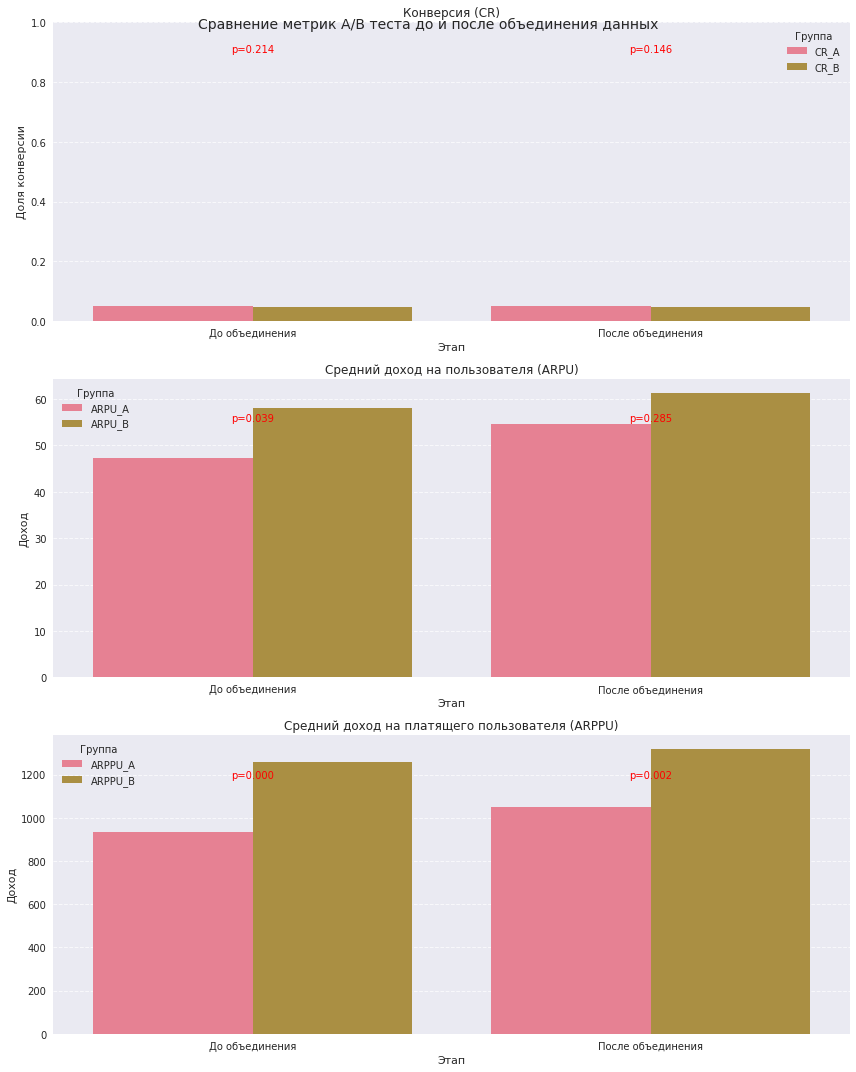

In [120]:
visualize_metrics(metrix)